In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Define directory path
data_dir = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'  # one folder with normal/benign/malignant inside

# Define parameters
img_size = (224, 224)
batch_size = 32
epochs = 30

# Function to create dataframe
def create_dataframe(dir_path):
    files = []
    labels = []
    for subdir in ['Normal', 'Bengin', 'Malignant']:
        subdir_path = os.path.join(dir_path, subdir)
        if os.path.exists(subdir_path):
            for file in os.listdir(subdir_path):
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    files.append(os.path.join(subdir, file))
                    labels.append(subdir)  # Keep original classes: normal, benign, malignant
    return pd.DataFrame({'filename': files, 'class': labels})

# Create dataframe
full_df = create_dataframe(data_dir)

train_df, temp_df = train_test_split(
    full_df,
    test_size=0.40,   # 60% train, 40% left
    stratify=full_df['class'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,    # split 40% into 20% val, 20% test
    stratify=temp_df['class'],
    random_state=42
)

print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")


# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # important for 3 classes
    color_mode='rgb'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Load pre-trained VGG19 without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')  # 3 output classes: normal, benign, malignant
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train with frozen layers
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // batch_size),
    epochs=epochs
)

# Fine-tuning: unfreeze last 4 layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // batch_size),
    epochs=epochs
)

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f'VGG19 Model Test Accuracy: {test_acc:.4f}')

# Save the model after fine-tuning
model.save('/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Model/lung_cancer_vgg19.h5')  # Save the model to a file (HDF5 format)
print("Model saved as 'lung_cancer_vgg19.h5'")

# --- To load the model later ---
# model = tf.keras.models.load_model('lung_cancer_vgg19.h5')


Train samples: 658, Validation samples: 219, Test samples: 220
Found 658 validated image filenames belonging to 3 classes.
Found 219 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4190 - loss: 1.2398 - val_accuracy: 0.4896 - val_loss: 0.9514
Epoch 2/30
 1/20 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.5625 - loss: 0.9238

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5625 - loss: 0.9238 - val_accuracy: 0.5156 - val_loss: 0.9402
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 691ms/step - accuracy: 0.5015 - loss: 0.9241 - val_accuracy: 0.5104 - val_loss: 0.9270
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4062 - loss: 1.1157 - val_accuracy: 0.5469 - val_loss: 0.8903
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 789ms/step - accuracy: 0.5651 - loss: 0.9154 - val_accuracy: 0.5312 - val_loss: 0.8789
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4688 - loss: 0.8752 - val_accuracy: 0.5417 - val_loss: 0.8862
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 685ms/step - accuracy: 0.5412 - loss: 0.9056 - val_accuracy: 0.6510 - val_loss: 0.8759
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7500 - loss: 0.7389 - val_accuracy: 0.6771 - val_loss: 0.8761
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 785ms/step - accuracy: 0.6305 - loss: 0.8830 - val_accuracy: 0.7344 - val_

VGG19 Model Test Accuracy: 0.8591
Model saved as 'lung_cancer_vgg19.h5'


In [ ]:
# ====================== IMPORTS ======================
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
try:
    from skimage.feature import greycomatrix, greycoprops, local_binary_pattern, hog
except ImportError:
    from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
    greycomatrix = graycomatrix
    greycoprops = graycoprops
from skimage.color import rgb2gray

# ====================== PARAMETERS ======================
IMG_SIZE = 224
LBP_POINTS = 24
LBP_RADIUS = 3

# ====================== FEATURE EXTRACTION ======================

def extract_deep_features(images):
    # Pre-trained VGG19 model without top layer
    base_model = VGG19(weights='imagenet', include_top=False, pooling='avg')
    processed_imgs = preprocess_input(images)
    features = base_model.predict(processed_imgs, verbose=0)
    return features

def extract_handcrafted_features(images):
    handcrafted_features = []
    for img in images:
        gray = rgb2gray(img / 255.0)
        glcm = greycomatrix((gray * 255).astype('uint8'), [1], [0], 256, symmetric=True, normed=True)
        glcm_features = [greycoprops(glcm, prop).ravel() for prop in
                         ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']]
        glcm_features = np.concatenate(glcm_features)

        lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
        lbp_hist = lbp_hist.astype('float') / (lbp_hist.sum() + 1e-6)

        features = np.concatenate([glcm_features, lbp_hist])
        handcrafted_features.append(features)
    return np.array(handcrafted_features)

def extract_features(img):
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_batch = np.expand_dims(img_resized, axis=0).astype('float32')
    deep_feat = extract_deep_features(img_batch)[0]
    hand_feat = extract_handcrafted_features([img_resized])[0]
    return np.concatenate([deep_feat, hand_feat])

# ====================== DATA PREPARATION ======================

def prepare_dataset(data_dir):
    images = []
    labels = []
    classes = ['Normal', 'Bengin', 'Malignant']

    for label in classes:
        class_dir = os.path.join(data_dir, label)
        if not os.path.exists(class_dir):
            continue
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if img is not None:
                    images.append(img)
                    labels.append(label)

    features = []
    print(f"Total images found: {len(images)}")
    for idx, img in enumerate(images):
        combined_features = extract_features(img)
        features.append(combined_features)
        if idx % 20 == 0:
            print(f"Processed {idx}/{len(images)} images...")

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

# ====================== MODEL TRAINING ======================

if __name__ == "__main__":
    # Dataset path
    dataset_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'

    # Prepare data
    features, labels = prepare_dataset(dataset_path)

    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

    # Define classifiers
    classifiers = {
        'SVM-RBF': SVC(kernel='rbf', probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'KNN (k=3)': KNeighborsClassifier(n_neighbors=3)
    }

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(f"\n{name} Classifier Results:")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, digits=4))


Total images found: 1097
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processed 0/1097 images...


Processed 20/1097 images...
Processed 40/1097 images...
Processed 60/1097 images...
Processed 80/1097 images...
Processed 100/1097 images...
Processed 120/1097 images...
Processed 140/1097 images...
Processed 160/1097 images...
Processed 180/1097 images...
Processed 200/1097 images...
Processed 220/1097 images...
Processed 240/1097 images...
Processed 260/1097 images...
Processed 280/1097 images...
Processed 300/1097 images...
Processed 320/1097 images...
Processed 340/1097 images...
Processed 360/1097 images...
Processed 380/1097 images...
Processed 400/1097 images...
Processed 420/1097 images...
Processed 440/1097 images...
Processed 460/1097 images...
Processed 480/1097 images...
Processed 500/1097 images...
Processed 520/1097 images...
Processed 540/1097 images...
Processed 560/1097 images...
Processed 580/1097 images...
Processed 600/1097 images...
Processed 620/1097 images...
Processed 640/1097 images...
Processed 660/1097 images...
Processed 680/1097 images...
Processed 700/1097

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from google.colab import drive



# Define directory path
data_dir = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'  # one folder with normal/benign/malignant inside

# Define parameters
img_size = (224, 224)
batch_size = 32
epochs = 10

# Function to create dataframe
def create_dataframe(dir_path):
    files = []
    labels = []
    for subdir in ['Normal', 'Bengin', 'Malignant']:
        subdir_path = os.path.join(dir_path, subdir)
        if os.path.exists(subdir_path):
            for file in os.listdir(subdir_path):
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):  # Adjust extensions as needed
                    files.append(os.path.join(subdir, file))
                    labels.append(subdir)  # Keep original classes: Normal, Bengin, Malignant
    return pd.DataFrame({'filename': files, 'class': labels})

# Create dataframe
full_df = create_dataframe(data_dir)

# Split into train/val/test (70% train, 10% val, 10% test)
train_df, temp_df = train_test_split(full_df, test_size=0.30, stratify=full_df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)


print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}, Testing samples: {len(test_df)}")

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # For 3 classes
    color_mode='rgb'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Load the pre-trained model from Google Drive
model_path = '/content/lung_cancer_vgg19.h5'  # Path to your saved model
model = load_model(model_path)

# Unfreeze some of the layers in the base model for fine-tuning
for layer in model.layers[-4:]:  # Unfreeze last 4 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // batch_size),
    epochs=epochs
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Fine-tuned VGG19 Model Test Accuracy: {test_acc:.4f}')

# Save the fine-tuned model back to Google Drive
fine_tuned_model_path = '/content/drive/MyDrive/lung_cancer_vgg19_fine_tuned.h5'
model.save(fine_tuned_model_path)
print(f"Fine-tuned model saved to {fine_tuned_model_path}")

# --- To load the model later ---
# model = tf.keras.models.load_model(fine_tuned_model_path)


Training samples: 767, Validation samples: 165, Testing samples: 165
Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8157 - loss: 0.4352 - val_accuracy: 0.8250 - val_loss: 0.4023
Epoch 2/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9688 - loss: 0.1468

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9688 - loss: 0.1468 - val_accuracy: 0.8375 - val_loss: 0.3725
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 898ms/step - accuracy: 0.8426 - loss: 0.3960 - val_accuracy: 0.8625 - val_loss: 0.3373
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9062 - loss: 0.3344 - val_accuracy: 0.8375 - val_loss: 0.3751
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 672ms/step - accuracy: 0.8691 - loss: 0.3508 - val_accuracy: 0.8750 - val_loss: 0.2698
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8438 - loss: 0.4116 - val_accuracy: 0.8813 - val_loss: 0.2670
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 688ms/step - accuracy: 0.8492 - loss: 0.3489 - val_accuracy: 0.8500 - val_loss: 0.3620
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9062 - loss: 0.2205 - val_accuracy: 0.8813 - val_loss: 0.3016
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 772ms/step - accuracy: 0.8697 - loss: 0.3257 - val_accuracy: 0.8875 - val

Fine-tuned VGG19 Model Test Accuracy: 0.8545
Fine-tuned model saved to /content/drive/MyDrive/lung_cancer_vgg19_fine_tuned.h5


TEST VGGSEGNET

In [ ]:
import os
import numpy as np
import cv2
import pydicom
import xml.etree.ElementTree as ET
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# segmentation.py
!pip install pydicom
import os
import pydicom
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pydicom
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
#                              DATA LOADING & PREPROCESSING
# -----------------------------------------------------------------------------

def load_dicom_original(dicom_path):
    """Load DICOM file, normalize to [0,1], convert to 3-channel RGB."""
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array.astype(np.float32)
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

def load_mask_original(xml_path, image):
    """
    Build a binary mask from XML bboxes + Otsu thresholding within each box.
    Returns 2D uint8 mask of same H×W as `image`.
    """
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for bbox in root.findall(".//bndbox"):
        xmin = max(0, int(bbox.find("xmin").text))
        ymin = max(0, int(bbox.find("ymin").text))
        xmax = min(w, int(bbox.find("xmax").text))
        ymax = min(h, int(bbox.find("ymax").text))
        if xmax <= xmin or ymax <= ymin:
            continue

        roi = image[ymin:ymax, xmin:xmax]
        gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        gray = (gray * 255).astype(np.uint8)
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        _, thr = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask[ymin:ymax, xmin:xmax] = thr

    # Clean with opening + dilation
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.dilate(mask, kernel, iterations=2)

    return mask

def map_dicom_to_xml(dicom_dir, xml_dir):
    """
    Walk xml_dir collecting XML filenames by SOPInstanceUID (filename w/o .xml).
    Then walk dicom_dir, read each .dcm, get SOPInstanceUID, and match.
    Returns paired lists of (dicom_path, xml_path).
    """
    uid_to_xml = {}
    for root, _, files in os.walk(xml_dir):
        for fname in files:
            if fname.endswith(".xml"):
                uid = fname[:-4]
                uid_to_xml[uid] = os.path.join(root, fname)

    dicom_paths = []
    xml_paths   = []
    for root, _, files in os.walk(dicom_dir):
        for fname in files:
            if not fname.lower().endswith(".dcm"):
                continue
            path = os.path.join(root, fname)
            ds = pydicom.dcmread(path, stop_before_pixels=True)
            sop = ds.SOPInstanceUID
            if sop in uid_to_xml:
                dicom_paths.append(path)
                xml_paths.append(uid_to_xml[sop])

    return dicom_paths, xml_paths

def prepare_dataset(dicom_dir, xml_dir, img_size=(224,224)):
    """
    Load every .dcm in `dicom_dir`.
    • If there’s a matching XML (by SOPInstanceUID), build the mask from it.
    • Otherwise, give it an all-zero mask (non-nodule).
    Returns:
      X → np.array, shape (N, H, W, 3), dtype float32
      Y → np.array, shape (N, H, W, 1), dtype float32 with values in {0,1}
    """
    # Build a map SOPInstanceUID → xml_path
    uid_to_xml = {}
    for root, _, files in os.walk(xml_dir):
        for fname in files:
            if fname.endswith(".xml"):
                uid = fname[:-4]
                uid_to_xml[uid] = os.path.join(root, fname)

    images, masks = [], []

    # Walk all DICOMs, load image + mask (real or zero)
    for root, _, files in os.walk(dicom_dir):
        for fname in files:
            if not fname.lower().endswith(".dcm"):
                continue
            dcm_path = os.path.join(root, fname)
            # Read header only
            ds = pydicom.dcmread(dcm_path, stop_before_pixels=True)
            sop = ds.SOPInstanceUID

            # Load & normalize image
            img = load_dicom_original(dcm_path)

            # Real mask if xml exists, else zeros
            if sop in uid_to_xml:
                msk = load_mask_original(uid_to_xml[sop], img)
            else:
                msk = np.zeros(img.shape[:2], dtype=np.uint8)

            # Resize both
            img_rs = cv2.resize(img, img_size)
            msk_rs = cv2.resize(msk, img_size, interpolation=cv2.INTER_NEAREST)

            images.append(img_rs)
            # Normalize mask from {0,255} to {0.0,1.0}
            masks.append(msk_rs[..., None].astype(np.float32) / 255.0)

    X = np.array(images, dtype=np.float32)
    Y = np.array(masks,  dtype=np.float32)  # now values are 0.0 or 1.0

    return X, Y


# -----------------------------------------------------------------------------
#                                 MODEL DEFINITION
# -----------------------------------------------------------------------------

def build_vgg19_segnet(input_shape=(224,224,3)):
    """
    VGG19 encoder + SegNet-style decoder.
    Output: single-channel sigmoid mask.
    """
    base = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    s1 = base.get_layer("block1_conv2").output  # 224×224×64
    s2 = base.get_layer("block2_conv2").output  # 112×112×128
    s3 = base.get_layer("block3_conv4").output  # 56×56×256
    s4 = base.get_layer("block4_conv4").output  # 28×28×512
    b  = base.get_layer("block5_conv4").output  # 14×14×512

    # Decoder

    def up_block(x, skip, filters):
        x = UpSampling2D()(x)
        x = Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = Dropout(0.5)(x)
        x = Concatenate()([x, skip])
        return x

    d1 = up_block(b,  s4, 512)
    d2 = up_block(d1, s3, 256)
    d3 = up_block(d2, s2, 128)
    d4 = up_block(d3, s1, 64)

    output = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model  = Model(inputs=base.input, outputs=output)
    return model

# -----------------------------------------------------------------------------
#                                  TRAINING
# -----------------------------------------------------------------------------



In [ ]:
if __name__ == "__main__":
    # Paths
    DICOM_DIR = "/content/drive/MyDrive/Lung-PET-CT-Dx/Lung_Dx-A0001"
    XML_DIR   = "/content/drive/MyDrive/Annotation/A0001"
    MODEL_DIR = "/content/drive/MyDrive/SortedDataset/model"
    os.makedirs(MODEL_DIR, exist_ok=True)

    # 1) Load & split data
    X, Y = prepare_dataset(DICOM_DIR, XML_DIR, img_size=(224,224))
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
    X_val, X_test, Y_val, Y_test     = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    print("Train:", X_train.shape, Y_train.shape)
    print("Val:  ", X_val.shape,   Y_val.shape)
    print("Test: ", X_test.shape,  Y_test.shape)

    # 2) Oversample nodule-positive slices
    pos_idx = [i for i, m in enumerate(Y_train) if m.sum() > 0]
    neg_idx = [i for i, m in enumerate(Y_train) if m.sum() == 0]
    ratio   = len(neg_idx) // max(1, len(pos_idx))
    extra   = len(neg_idx) % max(1, len(pos_idx))

    X_pos = X_train[pos_idx]
    Y_pos = Y_train[pos_idx]
    X_pos_rep = np.concatenate([X_pos]*ratio + [X_pos[:extra]], axis=0)
    Y_pos_rep = np.concatenate([Y_pos]*ratio + [Y_pos[:extra]], axis=0)

    X_train = np.concatenate([X_train[neg_idx], X_pos_rep], axis=0)
    Y_train = np.concatenate([Y_train[neg_idx], Y_pos_rep], axis=0)
    print(f"After oversampling: {X_train.shape[0]} train slices; positives → {Y_pos_rep.shape[0]}")

    # 3) Build model
    seg_model = build_vgg19_segnet(input_shape=(224,224,3))

    # 4) Define pixel-wise weighted BCE + Dice loss
    total_pix  = np.prod(Y_train.shape[1:]) * len(Y_train)
    pos_pix    = Y_train.sum()
    neg_pix    = total_pix - pos_pix
    pos_weight = float(neg_pix) / (pos_pix + 1e-8)

    def weighted_bce(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        w   = 1 + (pos_weight - 1) * y_true
        return K.mean(bce * w)

    def dice_loss(y_true, y_pred, smooth=1e-6):
        y_t   = K.flatten(y_true)
        y_p   = K.flatten(y_pred)
        inter = K.sum(y_t * y_p)
        return 1 - (2*inter + smooth) / (K.sum(y_t) + K.sum(y_p) + smooth)

    def combined_loss(y_true, y_pred):
        return weighted_bce(y_true, y_pred) + dice_loss(y_true, y_pred)

Train: (89, 224, 224, 3) (89, 224, 224, 1)
Val:   (19, 224, 224, 3) (19, 224, 224, 1)
Test:  (20, 224, 224, 3) (20, 224, 224, 1)
After oversampling: 156 train slices; positives → 78
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


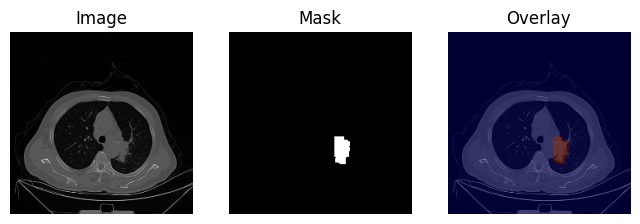

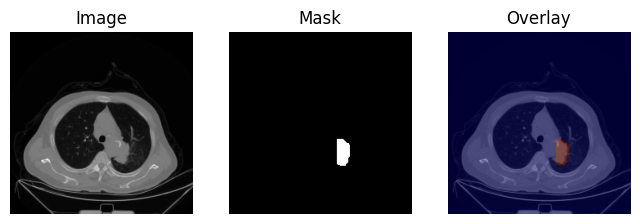

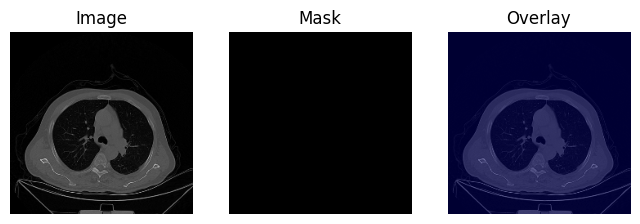

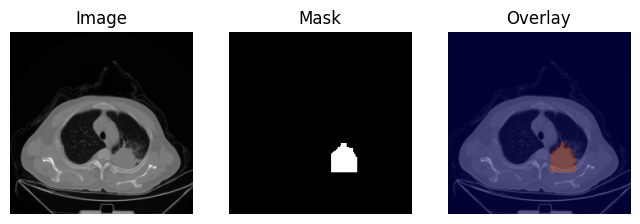

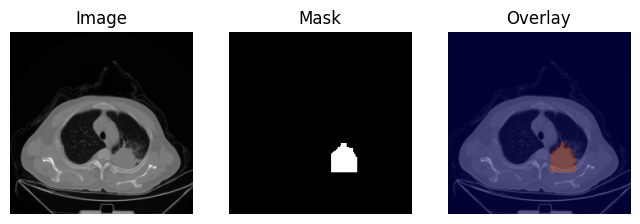

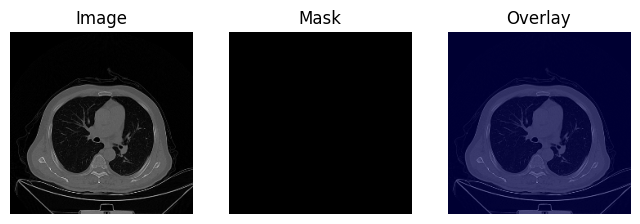

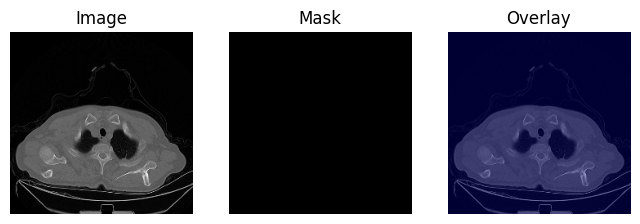

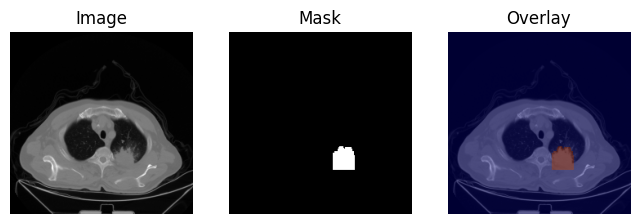

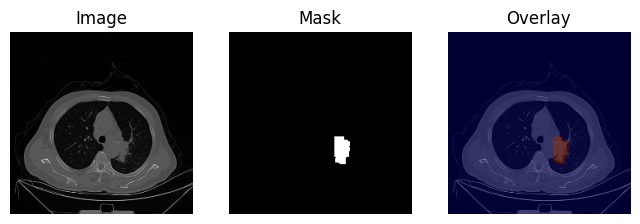

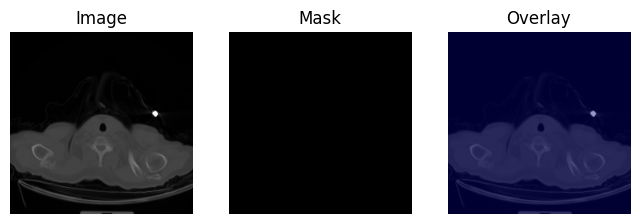

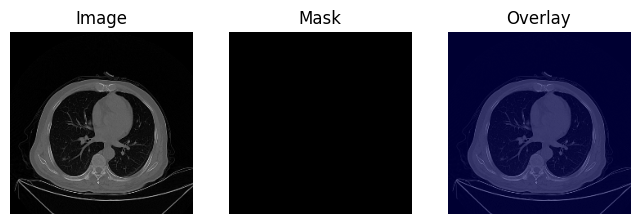

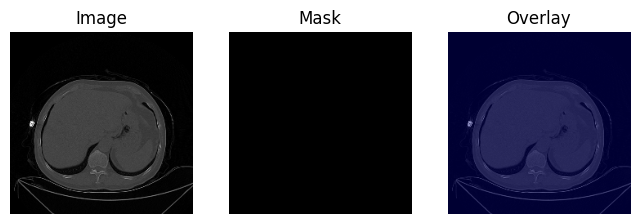

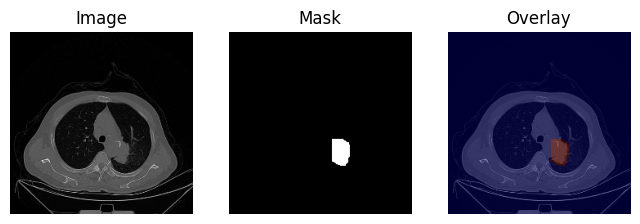

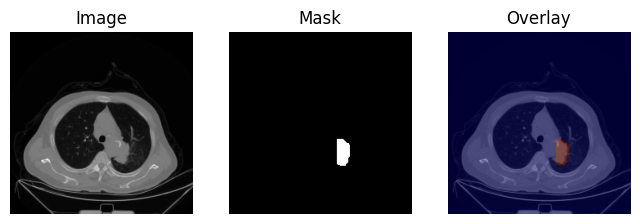

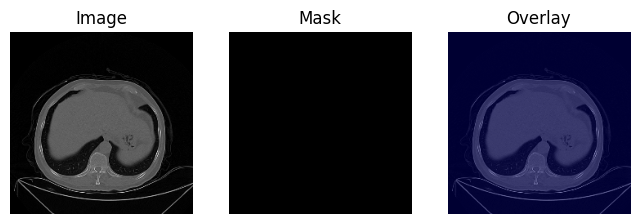

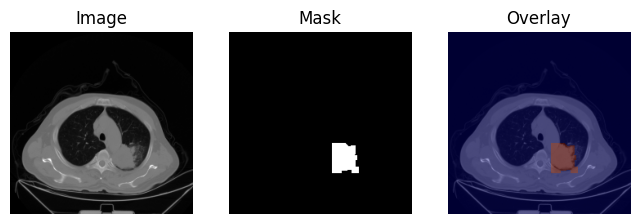

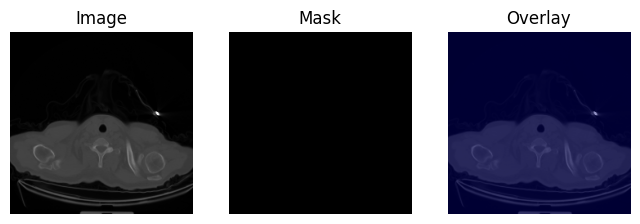

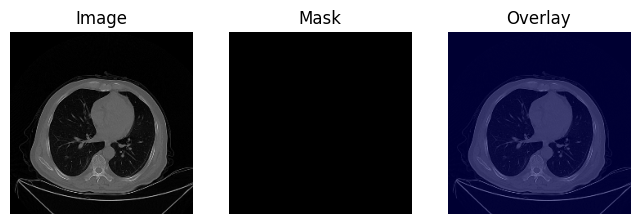

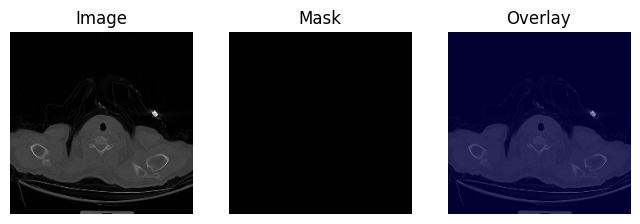

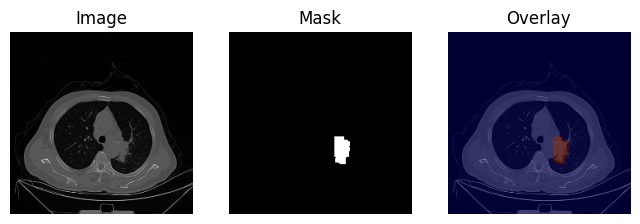

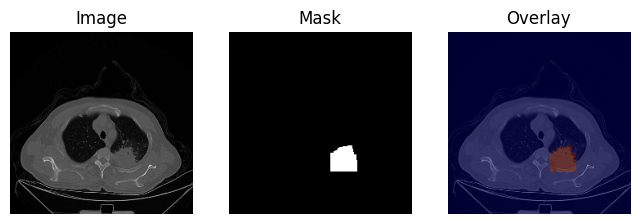

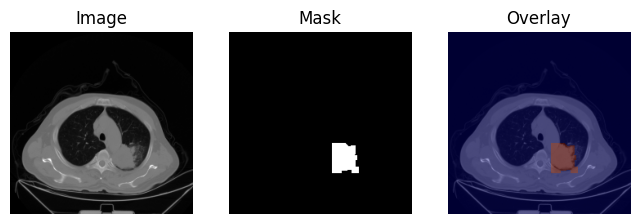

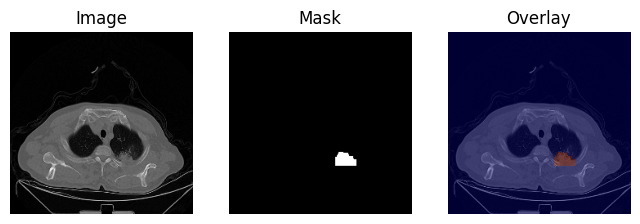

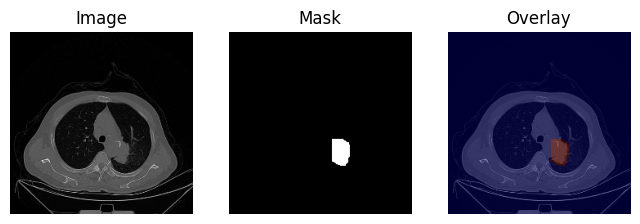

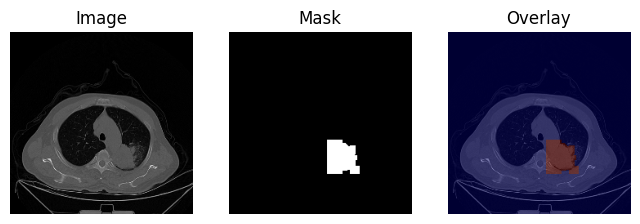

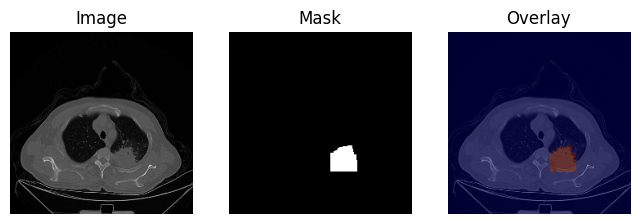

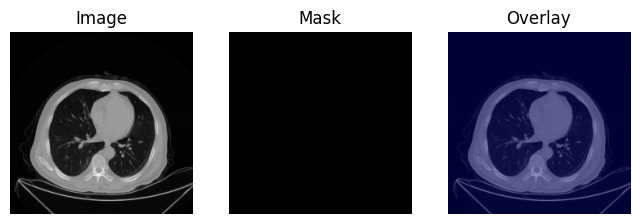

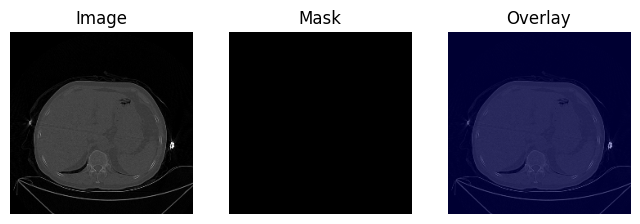

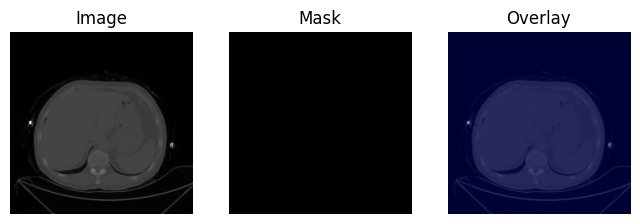

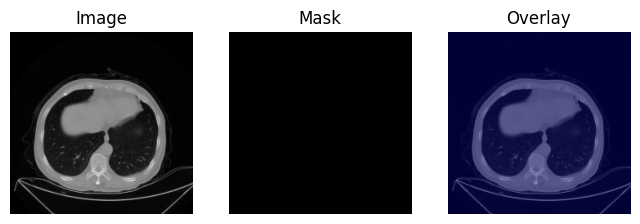

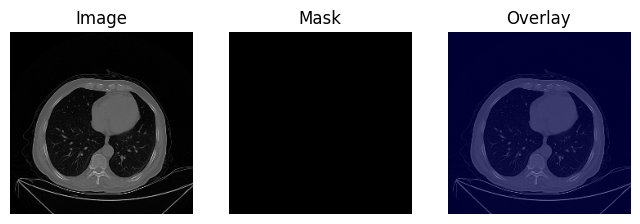

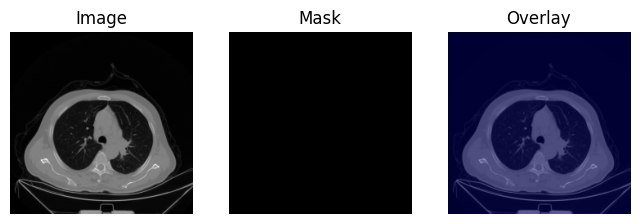

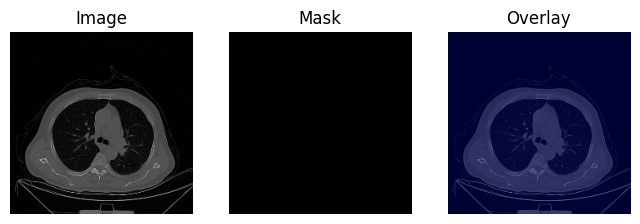

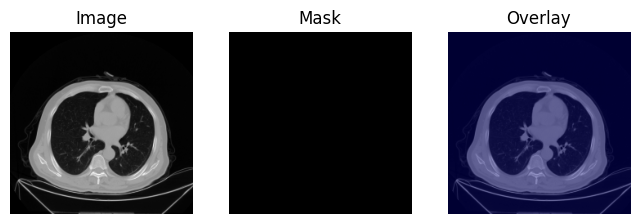

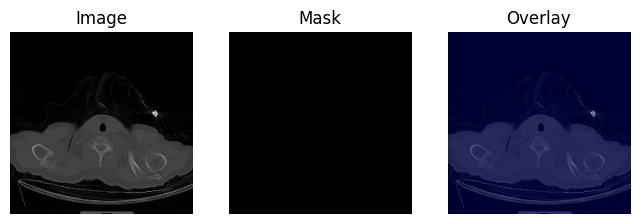

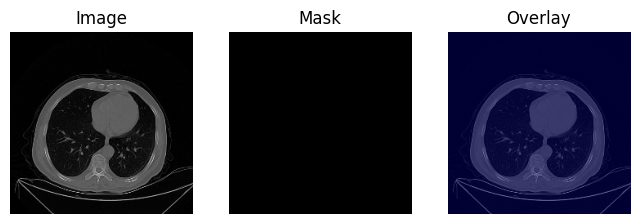

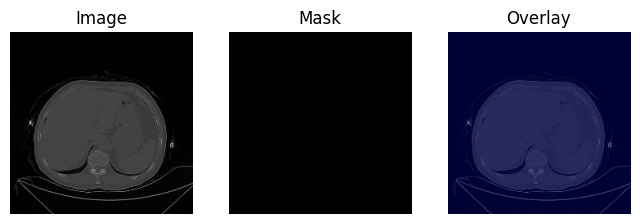

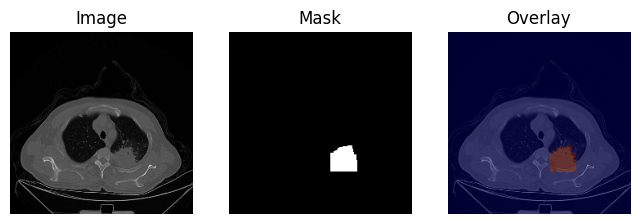

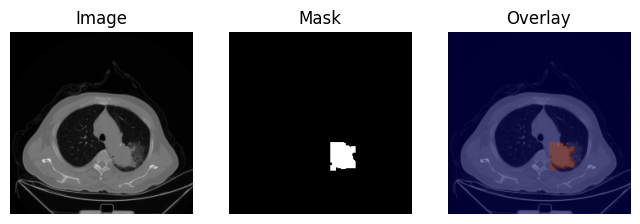

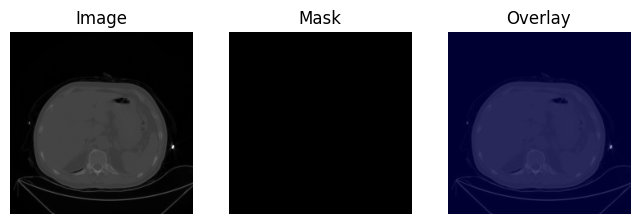

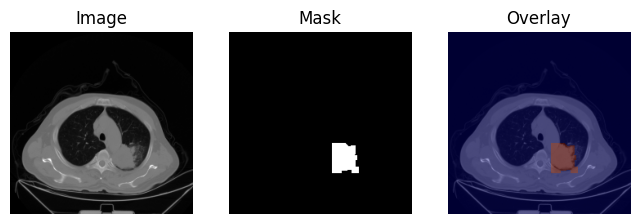

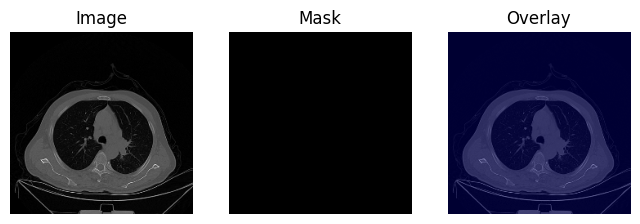

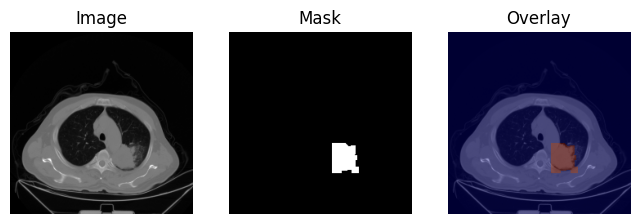

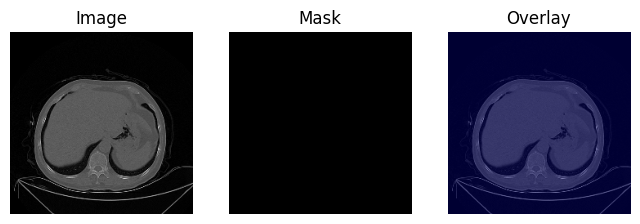

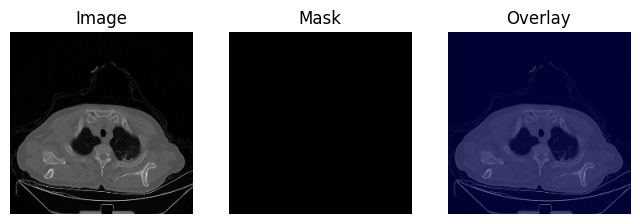

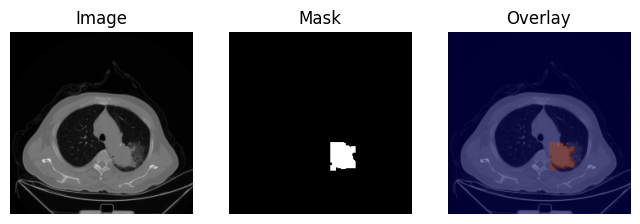

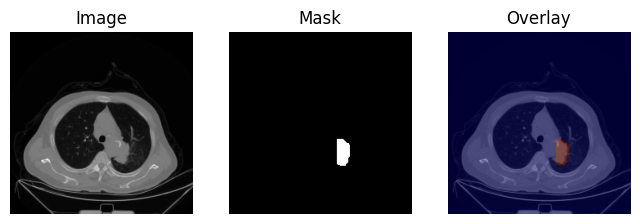

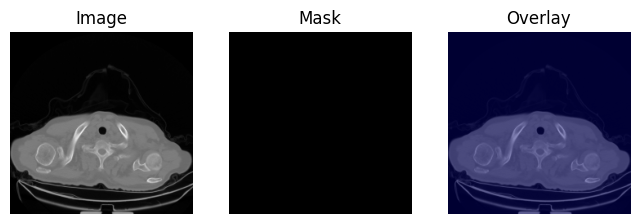

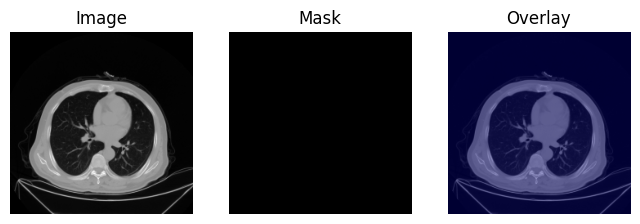

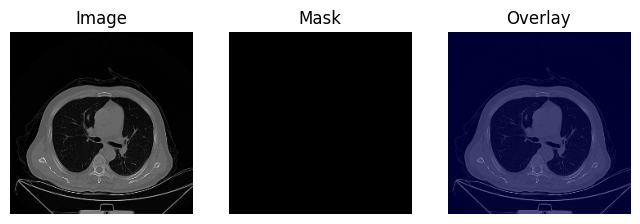

In [ ]:
   # 3) Optional: visualize a few samples before training
def visualize_samples(X, Y, n=50):
    idxs = np.random.choice(len(X), n, replace=False)
    for i in idxs:
        img = X[i]
        msk = Y[i].squeeze()
        plt.figure(figsize=(8,3))
        plt.subplot(1,3,1)
        plt.imshow(img[...,0], cmap="gray");  plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2)
        plt.imshow(msk, cmap="gray");        plt.title("Mask");  plt.axis("off")
        plt.subplot(1,3,3)
        plt.imshow(img[...,0], cmap="gray"); plt.imshow(msk, cmap="jet", alpha=0.4)
        plt.title("Overlay");              plt.axis("off")
        plt.show()
visualize_samples(X_train, Y_train, n=50)



In [ ]:
   # 6a) Stage 1: freeze encoder, train decoder at lr=1e-3
for layer in seg_model.layers[:19]:
    layer.trainable = False
seg_model.compile(
    optimizer=SGD(learning_rate=1e-3, momentum=0.9),
    loss=combined_loss,
    metrics=["accuracy"]
)
print(">>> Stage 1: decoder-only training @ lr=1e-3")
seg_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=2
)
# 6b) Stage 2: unfreeze all, fine-tune full model at lr=1e-5
for layer in seg_model.layers:
    layer.trainable = True
seg_model.compile(
    optimizer=SGD(learning_rate=1e-5, momentum=0.9),
    loss=combined_loss,
    metrics=["accuracy"]
)
print(">>> Stage 2: full-model fine-tuning @ lr=1e-5")
seg_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=2
)
# 7) Evaluate & save
loss, acc = seg_model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}, Test Acc: {acc:.4f}")
seg_model.save(os.path.join(MODEL_DIR, "vgg19_segnet_balanced.keras"))
print("✅ Model saved to", MODEL_DIR)

>>> Stage 1: decoder-only training @ lr=1e-3
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 800s 10s/step - accuracy: 0.6366 - loss: 7.2861 - val_accuracy: 0.7559 - val_loss: 1.5350
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 792s 10s/step - accuracy: 0.8880 - loss: 1.3820 - val_accuracy: 0.9349 - val_loss: 1.0832
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 804s 10s/step - accuracy: 0.9431 - loss: 1.1105 - val_accuracy: 0.9932 - val_loss: 0.9380
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 798s 10s/step - accuracy: 0.9656 - loss: 0.9481 - val_accuracy: 0.9928 - val_loss: 0.7738
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 804s 10s/step - accuracy: 0.9921 - loss: 0.5639 - val_accuracy: 0.9973 - val_loss: 0.7735
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 801s 10s/step - accuracy: 0.9889 - loss: 0.6431 - val_accuracy: 0.9985 - val_loss: 0.9634
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 788s 10s/step - accuracy: 0.9927 - loss: 0.5504 - val_accuracy: 0.9980 - val_loss: 0.8034
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 801s 10s/step - accur

10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step
Avg. Dice  on test set: 0.8627
Avg. IoU   on test set: 0.8353


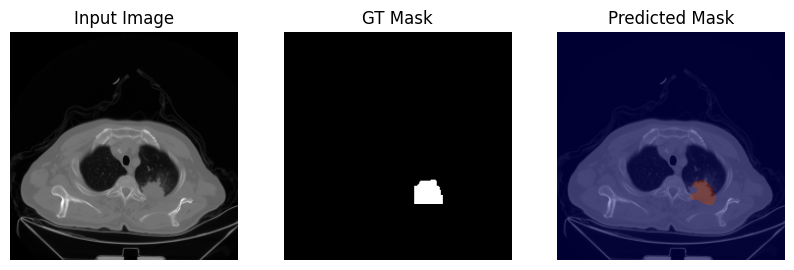

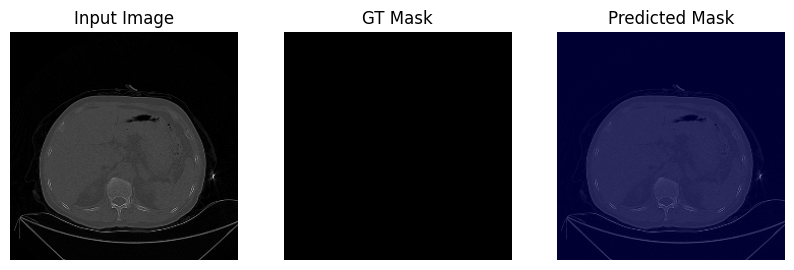

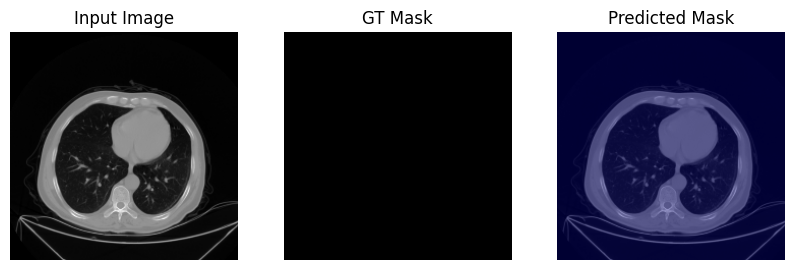

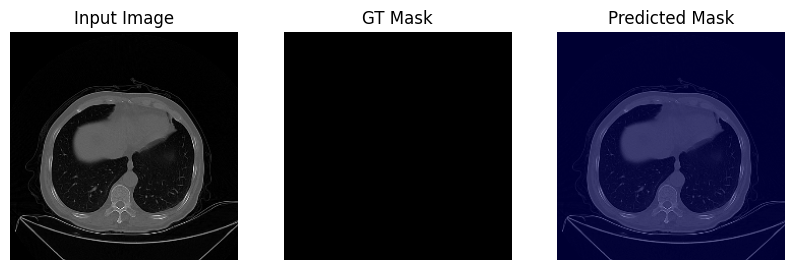

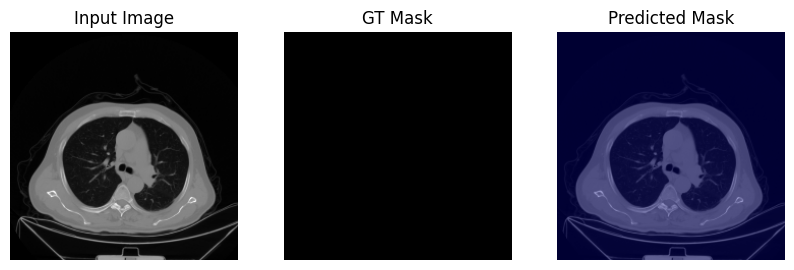

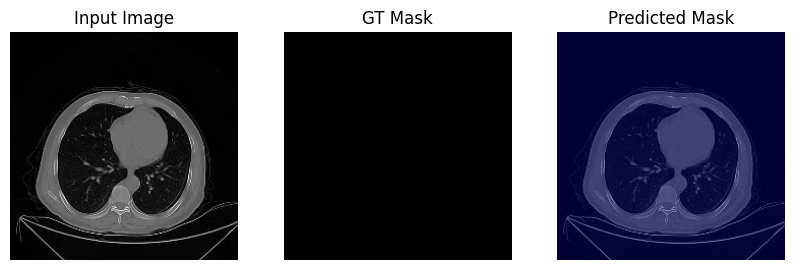

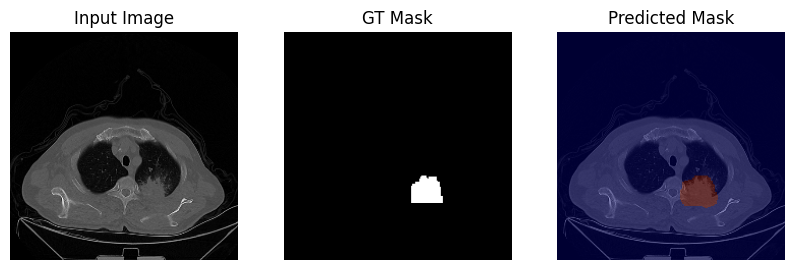

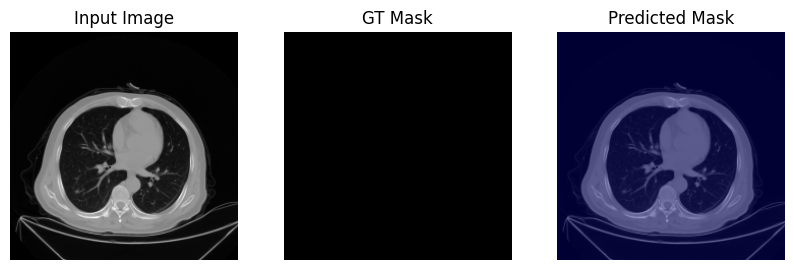

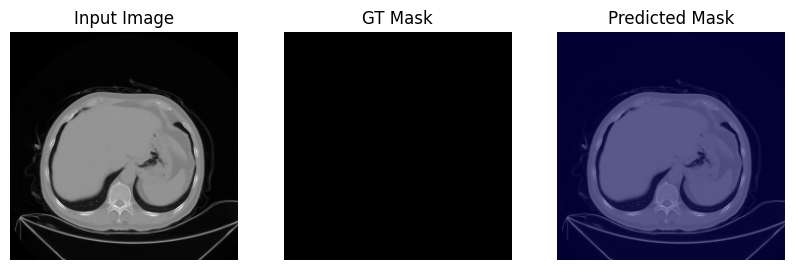

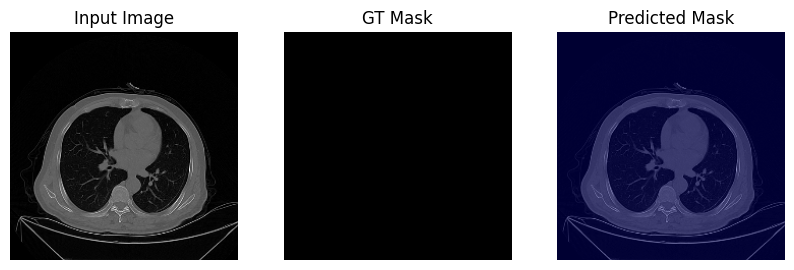

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

# 1) Load your test data (assuming you've already got X_test, Y_test in memory
#    or you can re-call prepare_dataset and split)
# from segmentation import prepare_dataset, map_dicom_to_xml  # etc.

# e.g.
# X, Y = prepare_dataset(DICOM_DIR, XML_DIR, img_size=(224,224))
# _, X_test, _, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# 2) Load the saved model
model = load_model(os.path.join(MODEL_DIR, "vgg19_segnet_balanced.keras"), compile=False)
model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

# 3) Predict on the test set
preds = model.predict(X_test, batch_size=2)             # shape (N,224,224,1)
preds_bin = (preds > 0.5).astype(np.uint8)

# 4) Define metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter   = np.sum(y_true_f * y_pred_f)
    return (2*inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter   = np.sum(y_true_f * y_pred_f)
    union   = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# 5) Compute average metrics over the test set
dices = [dice_coef(Y_test[i], preds_bin[i]) for i in range(len(Y_test))]
ious  = [iou_score (Y_test[i], preds_bin[i]) for i in range(len(Y_test))]
print(f"Avg. Dice  on test set: {np.mean(dices):.4f}")
print(f"Avg. IoU   on test set: {np.mean(ious) :.4f}")

# 6) Visualize a few examples
n_samples = 10
idxs = np.random.choice(len(X_test), n_samples, replace=False)
for i in idxs:
    img = X_test[i,...,0]        # grayscale background
    gt  = Y_test[i].squeeze()    # ground-truth mask
    pr  = preds_bin[i].squeeze() # predicted mask

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray");     plt.title("Input Image");  plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(gt, cmap="gray");      plt.title("GT Mask");       plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img, cmap="gray");
    plt.imshow(pr, cmap="jet", alpha=0.4); plt.title("Predicted Mask"); plt.axis("off")
    plt.show()


In [ ]:
# classification.py

#``python
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

# -------------------------------------------------------
# Handcrafted Feature Extraction Functions
# -------------------------------------------------------

def extract_phog_features(image, bins=3, levels=3):
    """
    Pyramid Histogram of Oriented Gradients (PHOG)
    image: 2D grayscale array
    returns a 255-dimensional vector
    """
    H, W = image.shape
    # Compute gradients
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = (np.arctan2(gy, gx) * (180 / np.pi)) % 180

    phog = []
    for l in range(levels + 1):
        cells = 2**l
        ch, cw = H//cells, W//cells
        for i in range(cells):
            for j in range(cells):
                cell_mag = magnitude[i*ch:(i+1)*ch, j*cw:(j+1)*cw]
                cell_ori = orientation[i*ch:(i+1)*ch, j*cw:(j+1)*cw]
                hist, _ = np.histogram(
                    cell_ori, bins=bins, range=(0,180), weights=cell_mag
                )
                if hist.sum() > 0:
                    hist = hist / hist.sum()
                phog.extend(hist)
    phog = np.array(phog)
    # Pad or trim to 255
    if phog.size < 255:
        phog = np.pad(phog, (0, 255 - phog.size), mode='constant')
    else:
        phog = phog[:255]
    return phog

def extract_glcm_features(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True):
    """
    Gray-Level Co-occurrence Matrix features
    image: 2D grayscale uint8 array
    returns a 25-dimensional vector
    """
    try:
      from skimage.feature import greycomatrix, greycoprops, local_binary_pattern, hog
    except ImportError:
        from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
        greycomatrix = graycomatrix
        greycoprops = graycoprops

    glcm = greycomatrix(
        image, distances=distances, angles=angles,
        levels=levels, symmetric=symmetric, normed=normed
    )
    props = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]
    feats = [greycoprops(glcm, p)[0,0] for p in props]
    # replicate to length 25
    feats = np.tile(feats, int(np.ceil(25/len(feats))))[:25]
    return np.array(feats)

def extract_lbp_features(image, P=8, R=1):
    """
    Local Binary Patterns (LBP)
    image: 2D grayscale array
    returns a 59-dimensional vector
    """
    from skimage.feature import local_binary_pattern
    lbp = local_binary_pattern(image, P, R, method="uniform")
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-6)
    # pad or trim to 59
    if hist.size < 59:
        hist = np.pad(hist, (0, 59 - hist.size), mode='constant')
    else:
        hist = hist[:59]
    return hist

def extract_handcrafted_features(image):
    """
    Concatenate GLCM (25-d), multi-radius LBP (4×59=236-d), and PHOG (255-d)
    into a 516-dimensional vector.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    fv_glcm = extract_glcm_features(gray)                            # 25
    fv_lbp = np.concatenate([extract_lbp_features(gray, P=8, R=r)
                              for r in [1,2,3,4]])                     # 236
    fv_phog = extract_phog_features(gray)                             # 255
    return np.concatenate([fv_glcm, fv_lbp, fv_phog])                 # 516

# -------------------------------------------------------
# Build Deep Feature Extractor (VGG19 -> FC2 -> 1024-d)
# -------------------------------------------------------

def build_deep_feature_extractor(input_shape=(224,224,3)):
    base = VGG19(weights="imagenet", include_top=True, input_shape=input_shape)
    x = base.get_layer("fc2").output      # 4096-dim
    x = Dense(1024, activation="relu")(x) # reduce to 1024
    return Model(inputs=base.input, outputs=x)

# -------------------------------------------------------
# Main Classification Workflow
# -------------------------------------------------------

if __name__ == "__main__":
    # Paths to your data and models
    SEG_MODEL_PATH = "/content/drive/MyDrive/SortedDataset/model/vgg19_segnet_balanced.keras"

    # Assume `X_images` is a numpy array of shape (N,224,224,3) with your images
    # and `y_labels` is a 1D array of length N with class labels (0=normal,1=nodule).
    # Load or construct these arrays as needed before running.

    # 1. Load segmentation model
    seg_model = load_model(SEG_MODEL_PATH, compile=False)

    # 2. Build deep feature extractor
    deep_extractor = build_deep_feature_extractor(input_shape=(224,224,3))

    # 3. Function to get concatenated features for one image
    def get_concatenated_features(image):
        # Predict mask
        pred_mask = seg_model.predict(image[None, ...])[0, ..., 0]
        binary_mask = (pred_mask > 0.5).astype(np.uint8)

        # Apply mask to image
        img_masked = (image * binary_mask[..., None]).astype(np.uint8)

        # Deep features (1024-d)
        deep_feat = deep_extractor.predict(image[None, ...])[0]

        # Handcrafted features (516-d)
        hcf = extract_handcrafted_features(img_masked)

        # Concatenate → 1540-d
        return np.concatenate([deep_feat, hcf])
    # Label = 1 (nodule) if the mask has any positive pixels; otherwise 0 (normal)
    y_labels = (Y_train.reshape(Y_train.shape[0], -1).sum(axis=1) > 0).astype(int)
    # 4. Extract features for all samples
    features = np.array([get_concatenated_features(img) for img in X_train])
    labels   = np.array(y_labels)

    # 5. Classification with SVM-RBF and 10-fold CV
    svm = SVC(kernel="rbf", C=1.0, gamma="scale")
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(svm, features, labels, cv=cv, scoring="accuracy")

    print(f"10-Fold CV Accuracy: {scores.mean()*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/